# Deep Learning & Art: Neural Style Transfer

<i>Maurizio Scibilia<br>
April the 2nd, 2020</i>

## Overview

In this project, taken from the end of the Convolutional Neural Networks course from Coursera, 
taught by Andrew NG, we are going to implement the <em>Neural Style Transfer</em> algorithm. This 
algorithm was created by Gatys et al. (2015)<br>
Most of the algorithms optimize a cost function to get a set of parameter values, while here we'll 
optimize a cost function to get pixel values!<br>
<br>
We will merge two images: a "content" image (C) and a "style" image (S), to create a "generated" image (G).
The generated image G will combines the "content" of the image C with the "style" of image S.
In this example, we are going to generate an image of my birthcity, Acireale, located in the south of Italy,
mixed with the famous painting by Vincent Van Gogh, <em>Starry Night</em> (style image S).

In [1]:
# loading packages
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. 
The idea of using a network trained on a different task and applying it to a new task is called transfer 
learning.<br><br>
Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, 
we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large 
ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and 
high level features (at the deeper layers).<br><br>
Run the following code to load parameters from the VGG model. This may take a few seconds.

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

W0403 10:00:09.281039 4816897472 deprecation_wrapper.py:119] From /Users/maurizioscibilia/Data_Science/Coursera/Deep Learning/course 04/week4/Neural Style Transfer/nst_utils.py:124: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

## Neural Style Transfer

### Computing the content cost

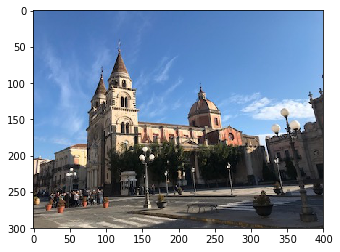

In [3]:
content_image = scipy.misc.imread("images/acireale_content.jpg")
imshow(content_image);

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled, a_C_unrolled))) * (1 / (4 * n_H * n_W * n_C))
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


### Computing the style cost

#### Style matrix

In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


#### Style cost

In [8]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) * (1 / (4 * n_C **2 * (n_H * n_W) **2))

    return J_style_layer

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


#### Style Weights

So far you have captured the style from only one layer.
We'll get better results if we "merge" style costs from several different layers.
Each layer will be given weights ( 𝜆[𝑙]) that reflect how much each layer will contribute to the style.

In [10]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [11]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

Description of compute_style_cost
----------------------------------------
For each layer:
- Select the activation (the output tensor) of the current layer.
- Get the style of the style image "S" from the current layer.
- Get the style of the generated image "G" from the current layer.
- Compute the "style cost" for the current layer
- Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:
- Return the overall style cost.

## Defining the total cost to optimize

In [12]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [13]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!
Here's what the program will have to do:
1. Create an Interactive Session
2. Load the content image
3. Load the style image
4. Randomly initialize the image to be generated
5. Load the VGG19 model
6. Build the TensorFlow graph:<br>
    i. Run the content image through the VGG19 model and compute the content cost<br>
    ii. Run the style image through the VGG19 model and compute the style cost<br>
    iii. Compute the total cost<br>
    iv. Define the optimizer and the learning rate.
7. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.
<br><br>
Lets go through the individual steps in detail.

### 1. Start the interactive session.

In [14]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

### 2. Content image

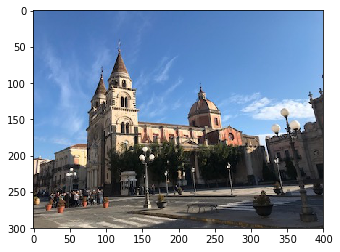

In [15]:
content_image = scipy.misc.imread("images/acireale_content.jpg")
imshow(content_image);

In [19]:
content_image = reshape_and_normalize_image(content_image)

### 3. Style image

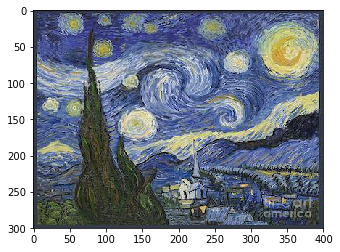

In [29]:
style_image = scipy.misc.imread("images/van_gogh_style.jpg")
imshow(style_image);

In [30]:
style_image = reshape_and_normalize_image(style_image)

### 4. Generated image correlated with content image

Now, we initialize the "generated" image as a noisy image created from the content_image.<br>
The generated image is slightly correlated with the content image.<br>
By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.<br>
Feel free to look in nst_utils.py to see the details of generate_noise_image(...); to do so.

W0403 12:22:12.528448 4816897472 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


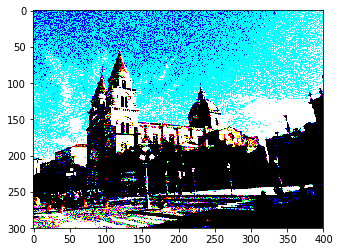

In [31]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

### 5. Load pre-trained VGG19 model

In [32]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

### 6i. Content Cost

To get the program to compute the content cost, we will now assign a_C and a_G to be the appropriate hidden 
layer activations. We will use layer conv4_2 to compute the content cost. The code below does the following:
- Assign the content image to be the input to the VGG model.
- Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
- Set a_G to be the tensor giving the hidden layer activation for the same layer.
- Compute the content cost using a_C and a_G.

Note: At this point, a_G is a tensor and hasn't been evaluated. 
    It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [33]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

### 6ii. Style Cost

In [34]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

### 6iii. Total Cost

In [35]:
# Use alpha = 10 and beta = 40
J = total_cost(J_content, J_style)

### 6iv. Optimizer

In [36]:
# Use Adam optimizer and a learning rate of 2.0

# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

### 7. Implement the model

In [37]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

## Generation

In [38]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 4650810000.0
content cost = 10236.979
style cost = 116267690.0
Iteration 20 :
total cost = 375587300.0
content cost = 16826.002
style cost = 9385476.0
Iteration 40 :
total cost = 123899944.0
content cost = 17985.844
style cost = 3093002.2
Iteration 60 :
total cost = 69665490.0
content cost = 18574.695
style cost = 1736993.6
Iteration 80 :
total cost = 47387280.0
content cost = 18931.203
style cost = 1179949.2
Iteration 100 :
total cost = 35699000.0
content cost = 19201.662
style cost = 887674.56
Iteration 120 :
total cost = 28677734.0
content cost = 19466.504
style cost = 712076.7
Iteration 140 :
total cost = 23991526.0
content cost = 19704.27
style cost = 594862.1
Iteration 160 :
total cost = 20682970.0
content cost = 19907.855
style cost = 512097.3
Iteration 180 :
total cost = 18206586.0
content cost = 20089.66
style cost = 450142.25


array([[[[-24.43248   , -18.01683   ,   1.5911547 ],
         [ -0.2782789 ,  22.683256  ,   4.7452316 ],
         [ 21.865181  ,  39.34164   ,  62.622242  ],
         ...,
         [ 10.5514965 ,  45.329723  ,  58.284813  ],
         [ 14.898997  ,  35.278095  ,  53.804497  ],
         [ 20.263395  ,  30.18276   ,  33.846573  ]],

        [[ -0.6498679 ,  21.444012  ,  41.774734  ],
         [ 19.96684   ,  29.89431   ,  44.817     ],
         [ 19.222557  ,  31.793468  ,  61.740707  ],
         ...,
         [ 12.797547  ,  37.070797  ,  51.985172  ],
         [  0.49206322,   8.182944  ,  33.05948   ],
         [ -8.100789  ,  -6.584849  ,  20.138046  ]],

        [[-65.93536   ,   7.2120643 ,  15.799292  ],
         [-52.676254  , -78.01056   , -34.87985   ],
         [-52.765335  , -44.691273  ,  -3.4069412 ],
         ...,
         [-32.30093   ,   1.3918047 ,   6.3137174 ],
         [  2.5364454 ,  15.496542  ,  47.721756  ],
         [ -0.8829957 ,  -0.19817218,  37.965107  ]],

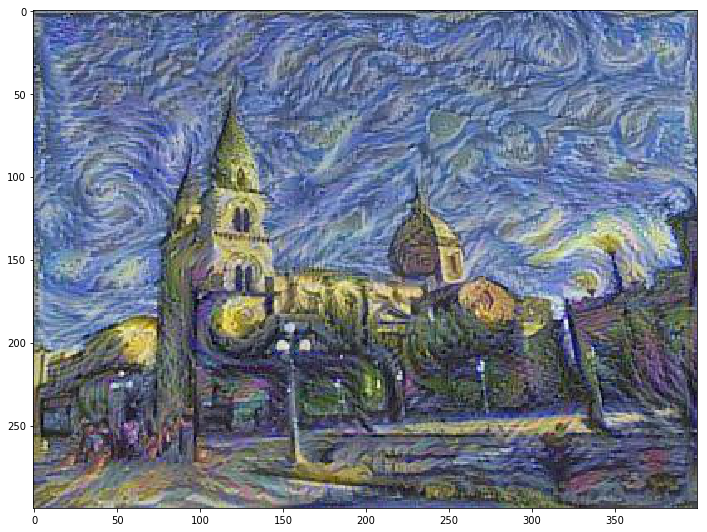

In [39]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10, 7.5))
generated_image = scipy.misc.imread("output/generated_image.jpg")
plt.imshow(generated_image)
plt.tight_layout()

## A different output

I just want to show a different output, that I got using the painting "Guernica" from Picasso.
This is <em>Guernica</em>:

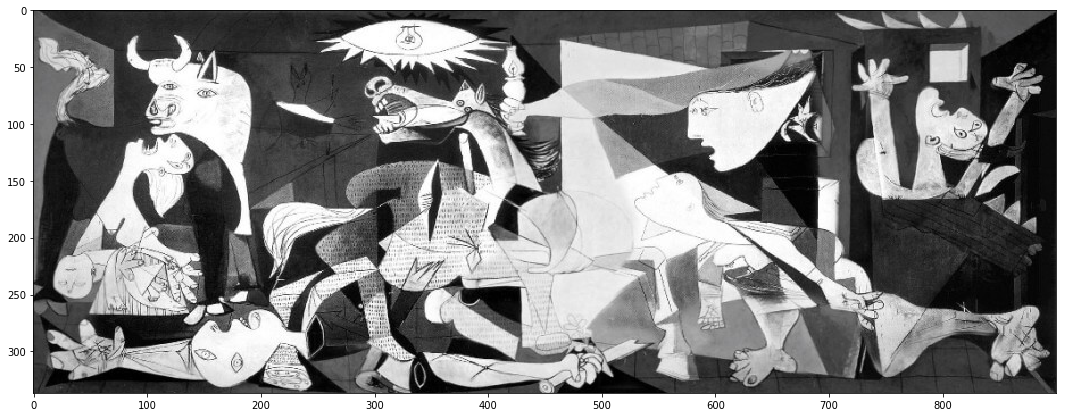

In [42]:
plt.figure(figsize = (15, 7.5))
guernica = scipy.misc.imread("images/guernica.jpg")
plt.imshow(guernica)
plt.tight_layout()

And this is the result:

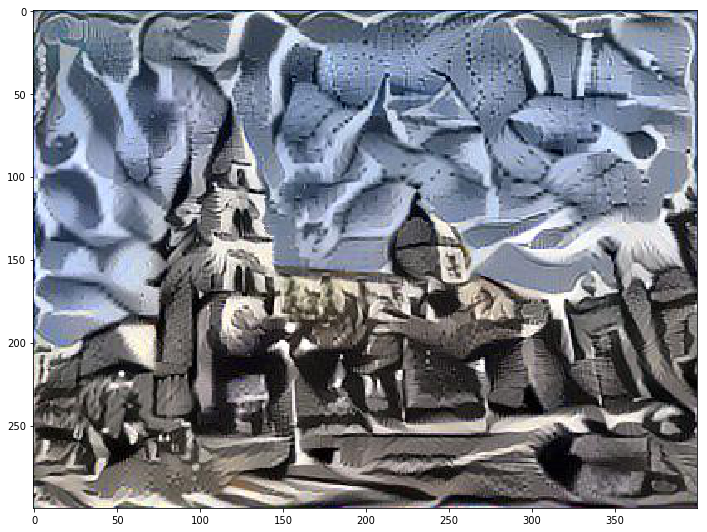

In [43]:
plt.figure(figsize = (10, 7.5))
picasso_generated = scipy.misc.imread("output/finished/picasso_generated.jpg")
plt.imshow(picasso_generated)
plt.tight_layout()